<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/gpt_parallelized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Mar 15 14:38:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameters

In [2]:
# hyperparameters
batch_size = 64 # num independent sequences processed in parallel 
block_size = 256 # maximum context length

max_iterations = 5001 #5001 # training iterations
eval_interval = 500 # after how many iterations to print out loss & accuracy
eval_iterations = 200 # batches to average over during evaluation

train_split = 0.9

dropout = 0.2
learning_rate = 1e-3 #3e-4

# model architecture
n_heads = 6
n_embedding = 384 # each head has dim 64 (=384/6)
n_layer = 3 #6

## Imports 

In [3]:
import torch
import torch.nn as nn
import time

try:
    import einops
except:
    print(f"einops not installed as required, installing...")
    !pip3 install einops
    import einops

from einops import rearrange, reduce, repeat

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cuda


## Download and pre-process data

In [5]:
# Importing data
data_file_path = 'https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/foundation.txt'
import requests
r = requests.get(data_file_path)
text = r.text

print(f"Length of foundation.txt: {len(text)} characters")
print(text[:250])
print()

chars = sorted(list(set(text)))
n_chars = len(chars)
print(f"There are {n_chars} unique characters, namely: {''.join(chars)}")

ctoi = {ch:i for i, ch in enumerate(chars)} # characters to integers
itoc = {i:ch for i, ch in enumerate(chars)} # integers to character
encode = lambda s: [ctoi[ch] for ch in s]
decode = lambda l: ''.join([itoc[i] for i in l])
print(encode("Hello world!"))
print(decode(encode("Foo Bar!")))

data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data) * 0.9)
train_data = data[:n]
test_data = data[n:]
print(f"train data length: {len(train_data)} | test data length: {len(test_data)}")

Length of foundation.txt: 1240544 characters
FOUNDATION 
ISAAC ASIMOV 

PART I 

THE PSYCHOHISTORIANS 

i. 

HARI SELDON-... bom In the 1 1,988th year of the Galactic Era; died 12,069. The dates are 
more commonly given In terms of the current Foundational Era as - 79 to the year 1 F.E. Born 
t

There are 84 unique characters, namely: 
 !"#%'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ\abcdefghijklmnopqrstuvwxyz—‘’”
[34, 58, 65, 65, 68, 1, 76, 68, 71, 65, 57, 2]
Foo Bar!
train data length: 1116489 | test data length: 124055


In [6]:
def get_batches(split='train') -> tuple:
  data = train_data if split == 'train' else test_data
  idxs = torch.randint(len(data)-block_size, (batch_size, ))
  xb = torch.stack([data[i:i+block_size] for i in idxs])
  yb = torch.stack([data[i+1:i+block_size+1] for i in idxs])
  xb, yb = xb.to(device), yb.to(device)
  return xb, yb

xb, yb = get_batches()
print(xb.shape, yb.shape)

torch.Size([64, 256]) torch.Size([64, 256])


In [7]:
def evaluate_model(model: nn.Module, eval_iterations = eval_iterations) -> dict:
  #12,000 outputs averaged
  t_eval = time.time()
  model.eval()
  with torch.inference_mode():
    splits = ['train', 'test']
    categories = ['loss', 'top1', 'top5']
    all = {s:{c: torch.zeros(eval_iterations) for c in categories} for s in splits}
    for split in splits:
      for i in range(eval_iterations):
        xb, yb = get_batches(split = split)
        logits, loss = model(xb, yb)
        all[split]['loss'][i] = loss.item()

        #Changing it to last element ONLY
        logits = logits[:, -1]# logits.shape, yb.shape = torch.Size([64, 84]), torch.Size([64])    
        yb = yb[:, -1]
        B = yb.shape[0]
        # top@1 accuracy
        top1_preds = torch.topk(logits, 1, dim = -1).indices
        all[split]['top1'][i] = 100*torch.sum(top1_preds == rearrange(yb, 'b -> b ()')).item()/B
        # top@5 accuracy
        top5_preds = torch.topk(logits, 5, dim = -1).indices
        all[split]['top5'][i] = 100*torch.sum(top5_preds == repeat(yb, 'b -> b k', k=5)).item()/B
  model.train()

  
  output_dict = {split:list(map(lambda a: round(a.mean().item(), 4), all[split].values())) for split in splits}
  output_dict['eval_time'] = round(time.time()-t_eval, 2)
  return output_dict

def format_output(output_dict, iter, train_time, loss):
  array = [iter,"|"]+output_dict['train']+['|']+output_dict['test']+['|']+[round(train_time,2),output_dict['eval_time'],'|',round(loss.item(),4)]
  title = 'iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)'
  header = "----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------"
  idxs = [0]
  for j in range(len(title)-1): 
    if title[j] == " " and title[j+1] != " ": idxs.append(j+1)
  output_str = ""
  for i in range(len(idxs)): output_str+=" "*(idxs[i]-len(output_str)) + f"{array[i]}"
  if iter == 0: output_str= header + '\n' + title + '\n' + output_str
  return output_str

In [8]:
# top1 SHOULD be higher
# {'train': [4.5447, 0.4896, 4.9479],
#  'test': [4.5419, 0.5729, 5.1562],
#  'eval_time': 20.96}
# 1/84 => 1.19% 
# However the frequency of each character varies. e.g. there will not be many colons
# At the momentum initialization it is (roughly) prediciting each equally, which
# explains the strange probability amount

## GPT model

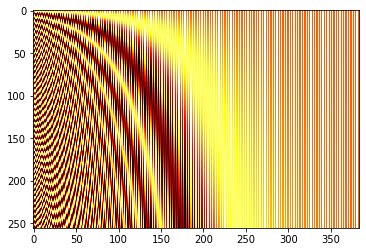

In [9]:
#Only bit of the code 'borrowed' from someone else ;)
import numpy as np
def get_positional_embeddings(sequence_length, n_embedding):
    result = torch.ones(sequence_length, n_embedding).to(device)
    for i in range(sequence_length):
        for j in range(n_embedding):
          if j % 2 == 0:
            result[i][j] = np.sin(i / (10000 ** (j / n_embedding)))
          else:
            result[i][j] = np.cos(i / (10000 ** ((j - 1) / n_embedding)))
    return result

import matplotlib.pyplot as plt
plt.imshow(get_positional_embeddings(block_size, n_embedding).cpu(), cmap="hot", interpolation="nearest")
plt.show()

In [10]:
class MultiHeadAttention(nn.Module):
  # parallelized attention heads
  
  def __init__(self):
    super().__init__()
    head_size = n_embedding // n_heads
    self.scale_factor = head_size**-0.5 # This scaling factor makes an INSANE difference

    #generating q,k,v for all n_heads at once
    self.qkv_linear = nn.Linear(n_embedding, head_size*n_heads*3) 
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Sequential(
        nn.Linear(head_size*n_heads, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape #[64, 256, 384])
    qkv = self.qkv_linear(x) # [64, 256, 1152]
    q, k, v =  rearrange(qkv, 'b t (qvk h c) -> qvk b h t c', qvk=3, h=n_heads) #torch.Size([3, 64, 6, 256, 64])

    mat_mul = q@rearrange(k, 'b h t c -> b h c t') * self.scale_factor
    mat_mul = mat_mul.masked_fill(self.tril[:T, :T]==0, float('-inf'))
    mat_mul = nn.functional.softmax(mat_mul, dim = -1)
    mat_mul = self.dropout(mat_mul)
    mat_mul = mat_mul@v
    flattened = rearrange(mat_mul, 'b h t c -> b t (h c)')
    linear = self.linear(flattened)
    return flattened

class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(n_embedding, 4*n_embedding),
        nn.GELU(),
        nn.Linear(4*n_embedding, n_embedding),
        nn.Dropout(dropout))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.feed_forward(x)

class Transformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.multi_attention = MultiHeadAttention() 
    self.feed_forward = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embedding)
    self.ln2 = nn.LayerNorm(n_embedding)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.multi_attention(self.ln1(x))
    x = x + self.feed_forward(self.ln2(x))
    return x

class GPT(nn.Module):
  def __init__(self):
      super().__init__()

      self.token_embeddings = nn.Embedding(n_chars, n_embedding)
      self.positional_encodings = nn.Parameter(get_positional_embeddings(block_size, n_embedding))# nn.Embedding(block_size, n_embedding)

      self.transformers = nn.Sequential(*[Transformer() for _ in range(n_layer)])

      self.final_ln = nn.LayerNorm(n_embedding)
      self.final_linear = nn.Linear(n_embedding, n_chars)
      
  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    T = x.shape[-1] # (B, T)
    te = self.token_embeddings(x) # (B T C)
    pe = self.positional_encodings[:T] #self.positional_encoding(torch.arange(T, device = device))
    x = te + pe 
    x = self.transformers(x)
    x = self.final_ln(x)
    logits = self.final_linear(x)
    if targets == None:
      loss = None
    else:
      B, T, C = logits.shape
      loss = nn.functional.cross_entropy(logits.view(B*T, C), targets.view(B*T))

    return logits, loss

  @torch.no_grad()
  def generate(self, idxs, length_to_generate=500) -> torch.Tensor:
    self.eval()
    for _ in range(length_to_generate):
      logits, loss = self(idxs[:, -block_size:])
      probs = nn.functional.softmax(logits[:, -1, :], dim = -1)
      pred = torch.multinomial(probs, 1)
      idxs = torch.cat((idxs, pred), dim = -1) # (B, T+1)
    self.train()
    return idxs

gpt_model = GPT().to(device)
print(f'gpt model parameters are on device: {next(gpt_model.parameters()).device}')
xb, yb = get_batches()
logits, loss = gpt_model(xb, yb)
print(f"{logits.shape}, {loss.item():.4f}")
print(f"{sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
print()
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=100)[0].tolist()))

gpt model parameters are on device: cuda:0
torch.Size([64, 256, 84]), 4.5564
5.4871 Million Parameters


n/tis5rWQ8-Soxt#b5X)n”)NiAg"P\9siJf3’:h”UUynfiHYDQiuA.)VScG*M:‘F‘#/PH7,5U4C/M-WbCvN;‘HYgh3MBB%8tJWos


## Training loop

In [11]:
### Training loop
optimizer = torch.optim.AdamW(params = gpt_model.parameters(), lr = learning_rate, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200) # T_mult=2

In [12]:
from tqdm import tqdm
losses = []
lrs = []
output_table = []
output_dicts = []

t_train = time.time()
t_train_full = time.time()
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
for i in tqdm(range(max_iterations)):
# for i in range(max_iterations):
  xb, yb = get_batches()
  logits, loss = gpt_model(xb, yb)
  if i % eval_interval == 0:
    train_time = time.time()-t_train
    output_dict = evaluate_model(gpt_model)
    output_dicts.append(output_dict)
    formatted = format_output(output_dict, i, train_time, loss)
    output_table.append(formatted)
    print(formatted)
    t_train = time.time()
  losses.append(loss.item())
  lrs.append(scheduler.get_last_lr())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  scheduler.step()
print(f"\nTime taken for {max_iterations} iterations: {time.time()-t_train_full:.2f} seconds")
print(f"n_heads:{n_heads} | n_embedding: {n_embedding} | n_layer: {n_layer} num_params: {sum(p.numel() for p in gpt_model.parameters())/1e6:.4f} Million Parameters")
for out in output_table: print(out)

n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters


  0%|          | 3/5001 [00:07<2:42:29,  1.95s/it] 

----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5476  0.4219      8.2656    |  4.5521  0.4062      7.9766    |  0.02            7.31


 10%|█         | 503/5001 [00:42<1:01:34,  1.22it/s]

500       |  1.8715  43.7031     78.6016   |  1.8903  43.0078     77.3359   |  28.03           7.31


 20%|██        | 1003/5001 [01:17<54:35,  1.22it/s]  

1000      |  1.453   53.9375     85.4844   |  1.4947  53.2656     84.8594   |  27.81           7.29


 30%|███       | 1503/5001 [01:52<47:58,  1.22it/s]  

1500      |  1.2853  60.1953     88.2656   |  1.365   58.5312     87.0703   |  27.73           7.32


 40%|████      | 2003/5001 [02:27<40:58,  1.22it/s]

2000      |  1.1833  63.2266     89.7578   |  1.2905  59.5625     87.4062   |  27.69           7.3


 50%|█████     | 2503/5001 [03:02<34:07,  1.22it/s]

2500      |  1.1445  64.3203     90.2734   |  1.2915  61.6406     88.2031   |  27.68           7.29


 60%|██████    | 3003/5001 [03:37<27:17,  1.22it/s]

3000      |  1.0737  66.4844     91.0      |  1.2671  62.7031     88.7031   |  27.72           7.29


 70%|███████   | 3503/5001 [04:13<20:31,  1.22it/s]

3500      |  1.0555  66.875      90.7656   |  1.2787  62.3672     88.3516   |  27.75           7.31


 80%|████████  | 4003/5001 [04:47<13:38,  1.22it/s]

4000      |  0.9917  68.7578     92.1406   |  1.2655  62.9844     88.6797   |  27.7            7.29


 90%|█████████ | 4503/5001 [05:23<06:48,  1.22it/s]

4500      |  0.9859  70.2812     92.9375   |  1.2948  62.0391     88.2188   |  27.72           7.29


100%|██████████| 5001/5001 [05:57<00:00, 13.97it/s]

5000      |  0.9196  71.4688     93.125    |  1.2816  63.3906     88.5781   |  27.7            7.27

Time taken for 5001 iterations: 357.88 seconds
n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5476  0.4219      8.2656    |  4.5521  0.4062      7.9766    |  0.02            7.31
500       |  1.8715  43.7031     78.6016   |  1.8903  43.0078     77.3359   |  28.03           7.31
1000      |  1.453   53.9375     85.4844   |  1.4947  53.2656     84.8594   |  27.81           7.29
1500      |  1.2853  60.1953     88.2656   |  1.365   58.5312     87.0703   |  27.73           7.32
2000      |  1.1833  63.2266     89.7578   |  1.2905  59.5625     87.4062   |  27.69           7.3
2500      |  1.1445  64.3203     90.2734   |  1.2915  

In [27]:
"""
Trying out different positional encoding:
conclusion: all seem the same lol

# fix sin and cos described in attention is all you need paper:
Time taken for 5001 iterations: 359.35 seconds
n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.3888 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.6211  0.5781      6.3984    |  4.6182  0.75        6.4375    |  0.02            7.37
500       |  1.8363  41.0078     76.8359   |  1.85    40.3594     76.1328   |  27.88           7.34
1000      |  1.4272  55.6016     85.4531   |  1.4707  54.3672     85.2578   |  27.85           7.34
1500      |  1.2742  60.1484     88.5234   |  1.3506  58.5859     86.8203   |  27.75           7.36
2000      |  1.17    64.1172     89.7109   |  1.2883  61.2656     88.2578   |  27.77           7.39
2500      |  1.1339  64.7812     90.4609   |  1.2909  61.8594     88.5547   |  27.9            7.38
3000      |  1.0642  67.3984     91.3047   |  1.2654  62.9375     88.7422   |  27.84           7.34
3500      |  1.0482  67.5        91.5078   |  1.2767  62.25       88.3281   |  27.76           7.36
4000      |  0.9834  69.3516     91.9766   |  1.2676  63.3281     88.7734   |  27.78           7.35
4500      |  0.9765  70.0781     92.5312   |  1.2912  63.2344     88.6797   |  27.87           7.37
5000      |  0.9125  71.6953     92.9844   |  1.2863  63.6172     88.6953   |  27.88           7.39

# With as a learnable parameter, starting with the sin & cos formula
Time taken for 5001 iterations: 357.88 seconds
n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5476  0.4219      8.2656    |  4.5521  0.4062      7.9766    |  0.02            7.31
500       |  1.8715  43.7031     78.6016   |  1.8903  43.0078     77.3359   |  28.03           7.31
1000      |  1.453   53.9375     85.4844   |  1.4947  53.2656     84.8594   |  27.81           7.29
1500      |  1.2853  60.1953     88.2656   |  1.365   58.5312     87.0703   |  27.73           7.32
2000      |  1.1833  63.2266     89.7578   |  1.2905  59.5625     87.4062   |  27.69           7.3
2500      |  1.1445  64.3203     90.2734   |  1.2915  61.6406     88.2031   |  27.68           7.29
3000      |  1.0737  66.4844     91.0      |  1.2671  62.7031     88.7031   |  27.72           7.29
3500      |  1.0555  66.875      90.7656   |  1.2787  62.3672     88.3516   |  27.75           7.31
4000      |  0.9917  68.7578     92.1406   |  1.2655  62.9844     88.6797   |  27.7            7.29
4500      |  0.9859  70.2812     92.9375   |  1.2948  62.0391     88.2188   |  27.72           7.29
5000      |  0.9196  71.4688     93.125    |  1.2816  63.3906     88.5781   |  27.7            7.27
"""
2

2

In [28]:
"""
With new accuracy function:
Time taken for 10001 iterations: 327.42 seconds
n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.6419  0.5625      3.0234    |  4.6435  0.6484      3.2656    |  0.02            7.29
1000      |  1.4401  56.2422     86.5312   |  1.4782  56.1953     86.1797   |  55.04           7.24
2000      |  1.2122  62.6484     89.1406   |  1.2938  60.9688     88.2344   |  54.86           7.26
3000      |  1.1216  65.7422     90.4219   |  1.2544  62.6172     88.3984   |  54.83           7.24
4000      |  1.0557  66.7578     90.9688   |  1.2415  63.8359     88.9141   |  54.86           7.25
5000      |  1.0036  68.7734     91.7734   |  1.2391  63.5859     88.9531   |  54.88           7.25


n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
  0%|          | 3/10001 [00:02<1:30:42,  1.84it/s]----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.584   1.1412      6.1035    |  4.5821  1.1642      6.1603    |  0.09            1.87
  5%|▌         | 503/10001 [00:31<39:02,  4.05it/s]500       |  1.7988  46.2958     80.4509   |  1.8199  45.9753     79.954    |  27.73           1.83
 10%|█         | 1003/10001 [01:01<36:53,  4.06it/s]1000      |  1.432   56.3521     86.3069   |  1.471   55.7946     85.7071   |  27.65           1.83
 15%|█▌        | 1503/10001 [01:30<34:46,  4.07it/s]1500      |  1.3028  59.8986     87.9591   |  1.3573  58.9292     87.1116   |  27.61           1.83
 20%|██        | 2003/10001 [01:59<32:51,  4.06it/s]2000      |  1.2121  62.3979     89.1371   |  1.2934  60.8557     87.9907   |  27.55           1.84
 25%|██▌       | 2503/10001 [02:29<30:41,  4.07it/s]2500      |  1.1753  63.4453     89.5761   |  1.2859  61.2456     88.0388   |  27.53           1.83
 30%|███       | 3003/10001 [02:58<28:40,  4.07it/s]3000      |  1.1164  65.031      90.2734   |  1.2533  62.2856     88.4114   |  27.55           1.83
 35%|███▌      | 3503/10001 [03:28<26:40,  4.06it/s]3500      |  1.0992  65.5531     90.5017   |  1.254   62.3793     88.4524   |  27.61           1.83
 40%|████      | 4003/10001 [03:57<24:37,  4.06it/s]4000      |  1.0545  66.8301     91.0563   |  1.2453  62.7485     88.5619   |  27.57           1.83
 45%|████▌     | 4503/10001 [04:26<22:35,  4.06it/s]4500      |  1.0458  67.0433     91.1292   |  1.2512  62.8126     88.5347   |  27.57           1.83
 50%|█████     | 5003/10001 [04:56<20:24,  4.08it/s]5000      |  0.9996  68.4211     91.6921   |  1.2396  63.0953     88.6704   |  27.59           1.82
 55%|█████▌    | 5503/10001 [05:25<18:23,  4.08it/s]5500      |  0.9959  68.4324     91.793    |  1.261   62.8334     88.495    |  27.59           1.83
 60%|██████    | 6003/10001 [05:55<16:22,  4.07it/s]6000      |  0.9494  69.8762     92.2613   |  1.2533  63.1045     88.6046   |  27.61           1.83
 65%|██████▌   | 6503/10001 [06:24<14:19,  4.07it/s]6500      |  0.9478  69.8766     92.3862   |  1.2711  62.7366     88.4548   |  27.58           1.83
 70%|███████   | 7003/10001 [06:53<12:17,  4.06it/s]7000      |  0.9082  71.0629     92.8336   |  1.2699  63.0359     88.5145   |  27.58           1.83
 75%|███████▌  | 7503/10001 [07:23<10:13,  4.07it/s]7500      |  0.9082  71.0662     92.8744   |  1.2844  62.7821     88.34     |  27.57           1.83
 80%|████████  | 8003/10001 [07:52<08:12,  4.06it/s]8000      |  0.8617  72.5555     93.3841   |  1.2862  62.9468     88.3911   |  27.59           1.83
 85%|████████▌ | 8503/10001 [08:22<06:10,  4.04it/s]8500      |  0.8677  72.3872     93.3359   |  1.3048  62.6736     88.1963   |  27.66           1.84
 90%|█████████ | 9003/10001 [08:51<04:05,  4.06it/s]9000      |  0.8229  73.7955     93.832    |  1.3058  62.8379     88.2317   |  27.57           1.83
 95%|█████████▌| 9503/10001 [09:21<02:02,  4.06it/s]9500      |  0.8326  73.425      93.7887   |  1.3252  62.5352     88.0333   |  27.55           1.83
100%|██████████| 10001/10001 [09:50<00:00, 16.94it/s]10000     |  0.7895  74.8445     94.2045   |  1.3187  62.8932     88.1986   |  27.55           1.83

Time taken for 10001 iterations: 590.41 seconds
n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.584   1.1412      6.1035    |  4.5821  1.1642      6.1603    |  0.09            1.87
500       |  1.7988  46.2958     80.4509   |  1.8199  45.9753     79.954    |  27.73           1.83
1000      |  1.432   56.3521     86.3069   |  1.471   55.7946     85.7071   |  27.65           1.83
1500      |  1.3028  59.8986     87.9591   |  1.3573  58.9292     87.1116   |  27.61           1.83
2000      |  1.2121  62.3979     89.1371   |  1.2934  60.8557     87.9907   |  27.55           1.84
2500      |  1.1753  63.4453     89.5761   |  1.2859  61.2456     88.0388   |  27.53           1.83
3000      |  1.1164  65.031      90.2734   |  1.2533  62.2856     88.4114   |  27.55           1.83
3500      |  1.0992  65.5531     90.5017   |  1.254   62.3793     88.4524   |  27.61           1.83
4000      |  1.0545  66.8301     91.0563   |  1.2453  62.7485     88.5619   |  27.57           1.83
4500      |  1.0458  67.0433     91.1292   |  1.2512  62.8126     88.5347   |  27.57           1.83
5000      |  0.9996  68.4211     91.6921   |  1.2396  63.0953     88.6704   |  27.59           1.82
5500      |  0.9959  68.4324     91.793    |  1.261   62.8334     88.495    |  27.59           1.83
6000      |  0.9494  69.8762     92.2613   |  1.2533  63.1045     88.6046   |  27.61           1.83
6500      |  0.9478  69.8766     92.3862   |  1.2711  62.7366     88.4548   |  27.58           1.83
7000      |  0.9082  71.0629     92.8336   |  1.2699  63.0359     88.5145   |  27.58           1.83
7500      |  0.9082  71.0662     92.8744   |  1.2844  62.7821     88.34     |  27.57           1.83
8000      |  0.8617  72.5555     93.3841   |  1.2862  62.9468     88.3911   |  27.59           1.83
8500      |  0.8677  72.3872     93.3359   |  1.3048  62.6736     88.1963   |  27.66           1.84
9000      |  0.8229  73.7955     93.832    |  1.3058  62.8379     88.2317   |  27.57           1.83
9500      |  0.8326  73.425      93.7887   |  1.3252  62.5352     88.0333   |  27.55           1.83
10000     |  0.7895  74.8445     94.2045   |  1.3187  62.8932     88.1986   |  27.55           1.83



with weight decay=0.1
Time taken for 5001 iterations: 203.21 seconds
n_heads:6 | n_embedding: 384 | n_layer: 2 num_params: 3.7126 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.6292  0.8373      4.7854    |  4.628   0.8474      4.8127    |  0.01            1.33
500       |  1.9136  42.6738     78.593    |  1.9301  42.7738     78.332    |  18.99           1.3
1000      |  1.5218  53.911      85.2147   |  1.5516  53.5409     84.6769   |  18.92           1.31
1500      |  1.3707  58.1523     87.2433   |  1.4206  57.2717     86.4146   |  18.94           1.3
2000      |  1.277   60.688      88.3286   |  1.3453  59.4631     87.4114   |  18.85           1.3
2500      |  1.2451  61.5126     88.804    |  1.3289  59.9728     87.6425   |  18.84           1.3
3000      |  1.1899  63.0548     89.4215   |  1.29    61.1451     88.0771   |  18.85           1.3
3500      |  1.175   63.4172     89.6188   |  1.2966  61.11       87.9314   |  18.81           1.3
4000      |  1.1356  64.5338     90.1057   |  1.2652  62.0295     88.3879   |  18.92           1.3
4500      |  1.1296  64.7013     90.176    |  1.2759  61.9012     88.1979   |  18.87           1.3
5000      |  1.0925  65.7245     90.5642   |  1.2591  62.451      88.4518   |  18.86           1.3


Time taken for 5001 iterations: 202.70 seconds
n_heads:6 | n_embedding: 384 | n_layer: 2 num_params: 3.7126 Million Parameters
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.6459  0.9249      4.9387    |  4.648   0.8961      4.8064    |  0.01            1.33
500       |  1.8458  44.9207     79.5494   |  1.8638  44.7742     79.2621   |  18.83           1.3
1000      |  1.4953  54.6135     85.4923   |  1.5199  54.1871     85.082    |  18.85           1.31
1500      |  1.3659  58.2286     87.1979   |  1.4105  57.3492     86.5706   |  18.81           1.3
2000      |  1.2834  60.4337     88.2312   |  1.3454  59.2491     87.3394   |  18.8            1.3
2500      |  1.2505  61.3564     88.6949   |  1.3255  59.9827     87.6213   |  18.81           1.3
3000      |  1.2045  62.6603     89.2275   |  1.2952  60.8926     87.9523   |  18.84           1.3
3500      |  1.1894  63.0231     89.429    |  1.2964  60.9778     87.8823   |  18.81           1.3
4000      |  1.153   64.0317     89.8479   |  1.2798  61.5676     88.1714   |  18.81           1.3
4500      |  1.1441  64.2983     89.9606   |  1.2861  61.4146     88.207    |  18.85           1.3
5000      |  1.1109  65.2509     90.2937   |  1.2628  62.1508     88.3591   |  18.9            1.3




n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
Time taken for 5001 iterations: 113.81 seconds
----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5965  1.1501      6.0497    |  4.5935  1.1541      6.0767    |  0.01            0.82
500       |  1.928   42.6768     78.3661   |  1.9465  42.4984     78.0266   |  10.51           0.79
1000      |  1.6109  51.3196     83.9252   |  1.6427  50.8079     83.4158   |  10.48           0.78
1500      |  1.5013  54.4125     85.4929   |  1.5328  54.0264     84.9203   |  10.54           0.78
2000      |  1.4212  56.5199     86.52     |  1.4671  55.6929     85.8688   |  10.52           0.78
2500      |  1.3932  57.3088     86.9452   |  1.4482  56.3748     86.1698   |  10.54           0.78
3000      |  1.3518  58.3597     87.4725   |  1.4129  57.4207     86.4638   |  10.52           0.78
3500      |  1.3466  58.5488     87.5354   |  1.4068  57.7091     86.6236   |  10.53           0.78
4000      |  1.3116  59.5636     87.8817   |  1.3808  58.2448     86.9263   |  10.51           0.78
4500      |  1.3109  59.5223     87.9717   |  1.3952  58.0879     86.8467   |  10.5            0.78
5000      |  1.2877  60.173      88.2081   |  1.3757  58.6683     86.9194   |  10.5            0.79



n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
  0%|          | 2/5001 [00:03<2:06:37,  1.52s/it]----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
0         |  4.5782  1.1344      5.996     |  4.581   1.1447      6.0018    |  0.03            3.44
500       |  1.8659  44.2059     79.5095   |  1.8838  44.0261     79.1359   |  53.11           3.42
1000      |  1.4122  56.9198     86.5447   |  1.4464  56.2103     86.0549   |  53.22           3.47
1500      |  1.2461  61.5043     88.7084   |  1.3171  60.0588     87.6467   |  53.13           3.43
2000      |  1.1379  64.4103     89.9736   |  1.2568  61.8655     88.3577   |  53.15           3.43
2500      |  1.0853  65.9414     90.631    |  1.2511  62.4436     88.4869   |  53.12           3.42
3000      |  1.0052  68.2371     91.5758   |  1.2286  63.2249     88.8038   |  53.13           3.42
3500      |  0.9713  69.1757     92.0682   |  1.2459  63.0121     88.6619   |  53.16           3.43
4000      |  0.8879  71.7495     92.9744   |  1.2529  63.3315     88.7118   |  53.1            3.44
4500      |  0.8576  72.6428     93.4435   |  1.2898  62.8986     88.4133   |  53.16           3.44
5000      |  0.7715  75.4623     94.36     |  1.3068  63.2018     88.3292   |  53.1            3.41
"""
1

1

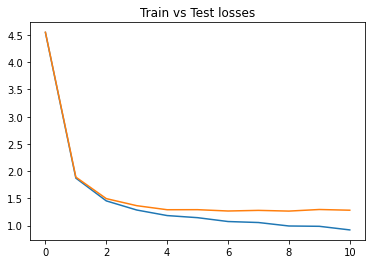

In [30]:
train_losses = []
test_losses = []
for array in output_dicts:
  train_losses.append(array['train'][0])
  test_losses.append(array['test'][0])

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title("Train vs Test losses")
plt.show()

In [18]:
# n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
# ----------|-------------TRAIN--------------|--------------TEST--------------|-------------TIMING--------------
# 0         |  4.5876  0.9868      5.2322    |  4.587   0.9653      5.2709    |  0.02            14.52
# 500       |  1.8428  44.7249     79.7544   |  1.8571  44.7034     79.4778   |  197.86          14.36
# 1000      |  1.3952  57.416      86.7649   |  1.4395  56.4691     86.054    |  197.48          14.3
# 1500      |  1.2384  61.7625     88.747    |  1.3163  60.1064     87.6062   |  196.82          14.31

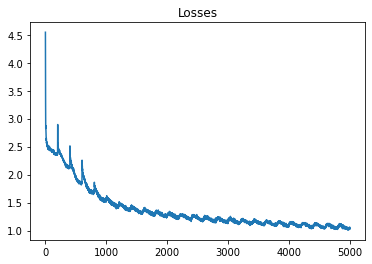

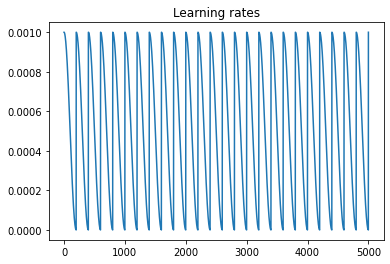

In [31]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Losses")
plt.show()

plt.plot(lrs)
plt.title("Learning rates")
plt.show()

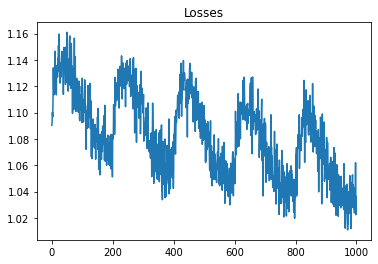

In [34]:
plt.plot(losses[-1000:])
plt.title("Losses")
plt.show()

In [21]:
# n_heads:6 | n_embedding: 384 | n_layer: 6 num_params: 10.8105 Million Parameters
# ----------|---------TRAIN----------|-----------TEST---------|----------TIMING---------
# iteration |  loss    top@1(%)    top@5(%)  |  loss    top@1(%)    top@5(%)  |  train_time(s)   eval_time(s)
# 0         |  4.609   1.4062      6.776     |  4.6062  1.4199      6.8174    |  0.02            13.45
# 500       |  2.2564  33.6514     71.0287   |  2.2728  33.572      71.0531   |  193.58          14.29



#Without lr scheduling:
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# With: 
#  1.4235   56.5724  86.4524  1.4637   55.8688  85.8688  7.8572 ### iter: 1000 | loss: 1.5045 | train interval: 209.32 seconds
#  1.2842   60.4039  88.2113  1.3478   59.2382  87.2946  7.8786 ### iter: 1000 | loss: 1.3604 | train interval: 208.99 seconds
# With lr scheduling


# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6333   0.9825   5.1626   4.6361   0.9424   5.0534   10.8289### iter: 0 | loss: 4.6345 | train time interval: 0.01 seconds
# 2.5013   27.6460  66.2090  2.5089   27.8167  66.1908  10.9146### iter: 100 | loss: 2.5085 | train time interval: 7.76 seconds
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
# n_heads:6 | n_embedding: 384 | n_layer: 1 num_params: 1.9381 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.6681   0.7924   4.6143   4.6686   0.7852   4.5937   10.1680### iter: 0 | loss: 4.6672 | train time interval: 0.01 seconds
# 2.5054   27.4399  65.9486  2.5082   27.7022  66.0398  10.2297### iter: 100 | loss: 2.5171 | train time interval: 6.53 seconds

# n_heads:6 | n_embedding: 384 | n_layer: 3 num_params: 5.4871 Million Parameters
# ---------TRAIN----------|-----------TEST-----------|--TIMING----------
# loss     top@1    top@5 |  loss     top@1    top@5 |  eval_time
# 4.5404   1.0071   6.0883   4.5384   0.9906   6.0388   27.0759 ### iter: 0 | loss: 4.5422 | train interval: 0.01 seconds
# 1.6008   51.8492  83.8604  1.6299   51.4921  83.3701  29.4928 ### iter: 1000 | loss: 1.6817 | train interval: 40.49 seconds
# 1.3288   59.2941  87.6776  1.3815   58.2792  86.9174  29.4365 ### iter: 2000 | loss: 1.4048 | train interval: 40.43 seconds
# 1.2257   62.0692  88.9917  1.3111   60.4550  87.8633  29.5504 ### iter: 3000 | loss: 1.3113 | train interval: 40.44 seconds
# 1.1591   63.8813  89.7406  1.2798   61.5125  88.2186  29.9780 ### iter: 4000 | loss: 1.2632 | train interval: 40.42 seconds
# 1.1068   65.3377  90.3494  1.2654   62.0324  88.2828  29.5430 ### iter: 5000 | loss: 1.2179 | train interval: 40.44 seconds
# Time taken for 5001 iterations: 1770.78 seconds (would be 1000 seconds if I evaluated every 1000 iterations, not 200)
# Note: #16 mins of training time, and 12 mins of eval time. Should just check every 1000 iterations(accidentally set it to 200)

In [35]:
context = torch.zeros((1, 1), dtype = torch.long,  device = device)
print(decode(gpt_model.generate(context, length_to_generate=200)[0].tolist()))


Then the mutation concerned to Luxor Plan. 

Channis looked up at his beneath and lit alone. 

The man guards he used together than an argument of his servant - and his men are quite difficult. 

Not 


In [36]:
for i in range(20):
  print("-"*100)
  sentence = "James Davey,"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
James Davey, too. In the first place, perhaps a pleasure, more have so been kindbated. There 
is no need it. It has been a fair cluster. And the guard's sunlessness melt so clear. They have 
sent their coins was disturbed cut off. The details of the universe and our new ready publishment 
among themselves and inevitable blasted for the day of the Temporal was a preparation before 
the rest of the navy intertial and walked off jewelly to start or or any sort occupied rightly 
upon the ship. 

Yet should say-
----------------------------------------------------------------------------------------------------
James Davey, 
"Would you lay him to all then?" 

The trader! Fie said, "/come. And therefore even them was excalled just the Second Foundation. 
Tributes will be overthrown your growing into deceler and representative you-" 

He smiled at the girl's eyes, dryly, "In the Galaxy would a

In [37]:
for i in range(5):
  print("-"*100)
  sentence = "Hardin, I say!"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
Hardin, I say! And found that are 
you dirty yourself to it, that I must say there's nothing of individual domination - not - 
the University of Education, even in the side of the Galaxy, who can all they want to 
do it, formed, and the dinner at all. The second who was they're deepened. There's a damned 
and walk of being at the Imperial project who says she had induct to be saw by the three others 
neither of the ato-prefect by the head. 

Before him lengthough he and time, when he wanted to Ebling Mis whos
----------------------------------------------------------------------------------------------------
Hardin, I say!" The continued with grandwards had deependence to the 
sufficient of the odier splints of the Mule. Then the tiny was not out to take him. He 
says of uturnity when all return. There is something of my own hours to us possess the since 
are so clear true the form my b

In [38]:
for i in range(10):
  print("-"*100)
  sentence = "Callum and Connor"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
Callum and Connorell 
and before Seldon, the Foundation. The planet lieutenant Second Empire kept ... to be. ... 
ay-" said Bayta, egfticuse. "You are stagnated. In fact, I thought have given out or bring or 
subtlessis eyes. Didn't you tell me what it seems ... this point comes? 

"A further myself question, I might citizens-" 

"No, that of guard is an electronic power and seem us, and you understand your apparentment 
by the truth might have finished into near and all of which, or 
you were born with the Asko
----------------------------------------------------------------------------------------------------
Callum and Connor the small dominate in 
power in any case, to when Seldon's clash psychologists could be puny reported. For it place 
when you'll forget me depend on when we gone in troubled the recorder, he'll have to do it." 


6 . 



And the turned out of his hand. "You'll h

In [39]:
for i in range(20):
  print("-"*100)
  sentence = " "
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
 dominion? He seems to bed. And teel 
great psychologists and disapportanced these remains being investigating among their lavish 
powers. Father, who now are alive. 

They confidently, but it's talking cars with me, there isn't anyone here. They did not put 
them to allow the room. Don't you need in that, that's trouble?" 

"I mean, Sir." 

"And if I had it to be the strange studied. Then I am not reply to such a new people, to listen, 
to have your resources." 

Randu leaned with with a large, 
----------------------------------------------------------------------------------------------------
 and Mis muttered. "The Mule has nothing. Therefore?" 

"Well, runnow," ground Bayta, stepped again, with a slow, he said, "I can't get you find out 
anything. You may lady know how of any now - longer for eat. Come in General Pritcher, captain. I 
am not even if I ought of it, I recognize than 

In [40]:
for i in range(10):
  print("-"*100)
  sentence = "The Mule"
  context= torch.tensor([encode(sentence)], dtype = torch.long, device = device)
  print(decode(gpt_model.generate(context, length_to_generate=500)[0].tolist()))

----------------------------------------------------------------------------------------------------
The Mule did not have called Seldon's 
first places. It's not five hundreds of science. I knew nothing much has been filled, that he 
hadn't even within, and our life addramatic regarding as to slidy of a sort of my way." He 
added, with it nothing means are capable before telling you that. There's nothing to be a strange 
at as are of searched inside to the skin. 

Then and while Mallow broke over his eyes and said: 

"And all one, since it points has would join the empty human would forever?" 

"Surel
----------------------------------------------------------------------------------------------------
The Mule felt was coldly accompunied. The evening department of a scramble 
unregarded with suchliqriness and the mechanical rammed what the called the rabble of away 
from the disparag emotional contractor? As long so, you get a few military before you ally 
twisted." 

"In the done, Imp

In [ ]:
"""
Hardin, I say!" 

His voice was an artificial cluster. "Did he to be detected. Where should himself to be strong, 
while I tell you I hear you the Plan, get into the Galaxy and you think I ask like the televisors 
of Salvor Hardin. You may be it fifty you have developed to him that anywhere, and I've been 
affective is it right to to have your prisoner?" 

"I don't quite him of the correct - and threats are not betray lost in the apiece of cloaking as 
sky. Yes, then we can't help?" 
"""
1